In [1]:
from collections import Counter
import json
import os
import sys

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from scipy.stats import norm, skew
from scipy.optimize import curve_fit
from sklearn.linear_model import LogisticRegression


sys.path.append(os.path.abspath(".."))

from config import (
    TRAIN_DATA_PATH,
    RECOMMENDATIONS_PATH,
    USER_EVAL_PATH,
    RECOMMENDERS,
    EVALUATION_METRICS,
    METADATA_PATH,
)
import utils

c:\Users\sewr\AppData\Local\anaconda3\envs\dr-podcast-recsys\lib\site-packages\lightfm\_lightfm_fast.py:9: UserWarning: LightFM was compiled without OpenMP support. Only a single thread will be used.
  warnings.warn(


### Popularity Bias
Comparison of the distribution of plays per episode in the training data and the distribution of recommendations for each recommender.

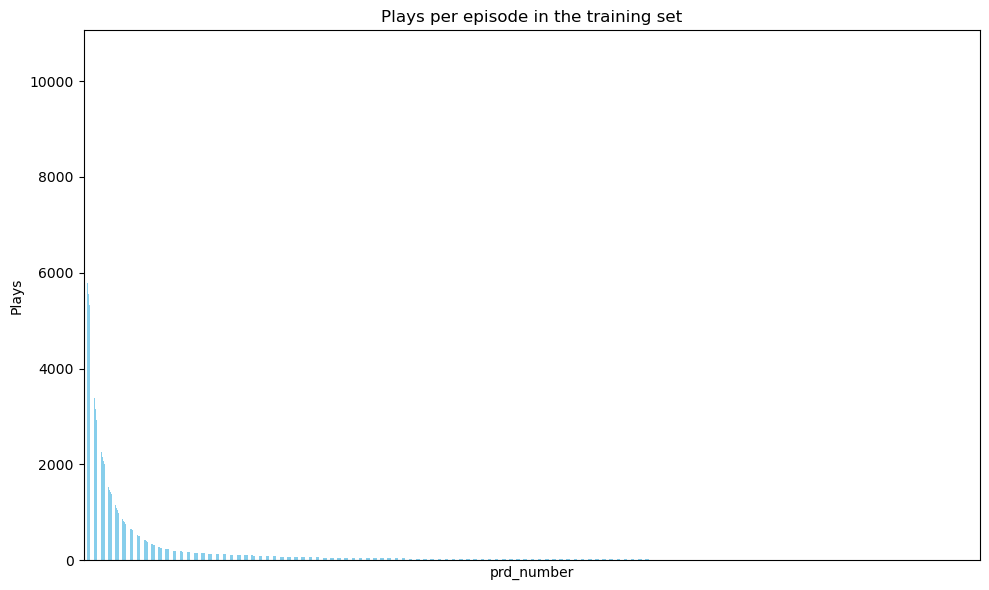

In [10]:
# loading training data
train_df = pd.read_parquet("../" + TRAIN_DATA_PATH)

# counting occurrences of each prd_number
prd_counts = train_df['prd_number'].value_counts()

# plotting the prd_numbers against their occurrences
plt.figure(figsize=(10, 6))
prd_counts.plot(kind='bar', color='skyblue')

# adding title and labels
plt.title('Plays per episode in the training set')
plt.xlabel('prd_number')
plt.ylabel('Plays')

# removing x-axis ticks
plt.xticks([], []) 

# adjusting layout and show the plot
plt.tight_layout()
plt.show()

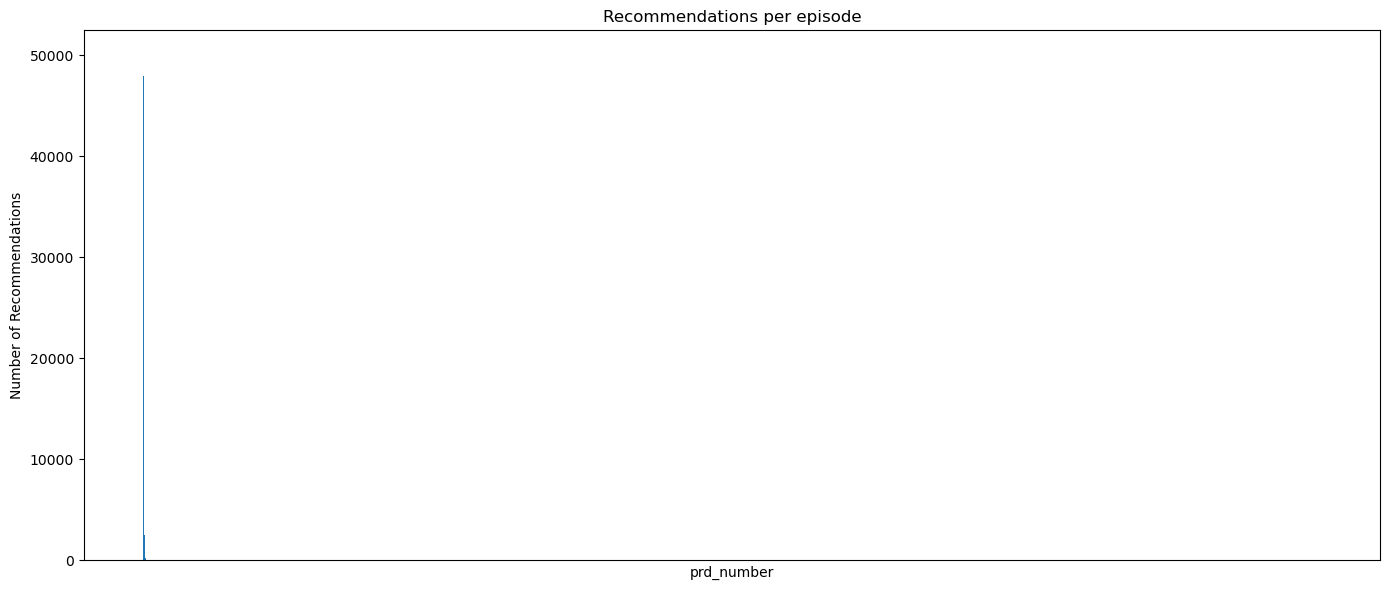

In [11]:
# Open and load the JSON file
with open("../" + RECOMMENDATIONS_PATH, "r") as file:
    data = json.load(file)

recommendations = data["cf_recommendations"]

# Flatten all recommended episodes
all_episodes = [episode for rec_list in recommendations.values() for episode in rec_list]

# Count recommended episodes
episode_counts = Counter(all_episodes)

# Get all episodes from train_df
all_prd_numbers = train_df["prd_number"].unique().astype(str)  # make sure they are strings

# Ensure all episodes are in the count dictionary (with 0 if not present)
for ep in all_prd_numbers:
    episode_counts.setdefault(ep, 0)

# Sort by descending count
sorted_episodes = episode_counts.most_common()

# Unpack for plotting
episodes, counts = zip(*sorted_episodes)

# Plotting
plt.figure(figsize=(14, 6))
plt.bar(episodes, counts)

# removing x-axis ticks
plt.xticks([], []) 

# adding labels, title, and adjusting layout
plt.xlabel("prd_number")
plt.ylabel("Number of Recommendations")
plt.title("Recommendations per episode")
plt.tight_layout()
plt.show()

Measuring the skewness of the two distributions:

In [12]:
# skewness of the distribution of plays in the training set
plays_skewness = skew(prd_counts.values)
print(f"Skewness of the distribution of plays: {plays_skewness}")

# skewness of the distribution of recommendations
recommendation_skewness = skew(counts)
print(f"Skewness of the distribution of recommendations: {recommendation_skewness}")

Skewness of the distribution of plays: 6.9403960176365675
Skewness of the distribution of recommendations: 31.2276999392981


Computing Z-score for significance testing (Z-test):

In [13]:
# using bootstrapping to estimate the standard deviation of the skewness
np.random.seed(250500)

def bootstrap_ses(data, n_bootstrap=1000):
    skew_samples = []
    for _ in range(n_bootstrap):
        sample = np.random.choice(data, size=len(data), replace=True)
        skew_samples.append(skew(sample))
    return np.std(skew_samples)

ses_model = bootstrap_ses(counts)
ses_observed = bootstrap_ses(prd_counts.values)

z = (recommendation_skewness - plays_skewness) / np.sqrt(ses_model**2 + ses_observed**2)
print(f"Z-score: {z}")

# computing the two-tailed p-value
p_value = 2 * (1 - norm.cdf(abs(z)))
print(f"P-value: {p_value}")

Z-score: 4.184412860838507
P-value: 2.8590408895023955e-05


### User Bias
Assessing performance metrics against the number of training interactions for each user.

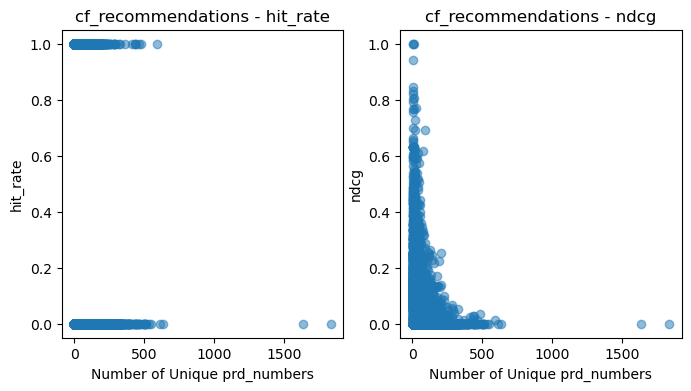

In [8]:
# loading the training data
train_df = pd.read_parquet("../" + TRAIN_DATA_PATH)

# grouping by user_id and counting the number of unique prd_numbers for each user
user_counts = train_df.groupby("user_id")["prd_number"].nunique()

# loading evaluation metrics for each user
with open("../" + USER_EVAL_PATH, "r") as file:
    data = json.load(file)

# initializing subplots
n_recommenders = len(RECOMMENDERS)
n_metrics = len(EVALUATION_METRICS)
fig, axes = plt.subplots(n_recommenders, 
                         n_metrics, 
                         figsize=(4*n_metrics, 4*n_recommenders))

for recommender in RECOMMENDERS:
    # extracting the recommendations for the current recommender
    user_metrics = data[recommender]

    # converting the user_metrics into a DataFrame
    user_metrics_df = pd.DataFrame(user_metrics).reset_index()
    user_metrics_df.columns = ['user_id'] + list(user_metrics.keys())

    # left joining the user_metrics_df with the user_counts
    merged_df = user_metrics_df.merge(user_counts.reset_index(), on='user_id', how='left')

    # plotting each metric against the number of unique prd_numbers
    for i, metric in enumerate(EVALUATION_METRICS):
        ax = axes[i]
        ax.scatter(merged_df["prd_number"], merged_df[metric], alpha=0.5)
        ax.set_title(f"{recommender} - {metric}")
        ax.set_xlabel("Number of Unique prd_numbers")
        ax.set_ylabel(metric) 

The data contains two clear outliers representing users with >1500 episodes listened to in the training data. I will discard these two outliers before applying any fit.

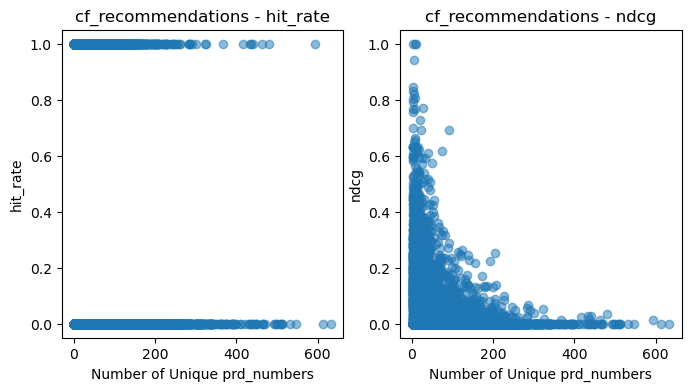

In [9]:
# removing outliers 
merged_df_filtered = merged_df[merged_df["prd_number"] < 1500]

# initializing subplots
n_recommenders = len(RECOMMENDERS)
n_metrics = len(EVALUATION_METRICS)
fig, axes = plt.subplots(n_recommenders, 
                         n_metrics, 
                         figsize=(4*n_metrics, 4*n_recommenders))

for recommender in RECOMMENDERS:
    # plotting each metric against the number of unique prd_numbers
    for i, metric in enumerate(EVALUATION_METRICS):
        ax = axes[i]
        ax.scatter(merged_df_filtered["prd_number"], merged_df_filtered[metric], alpha=0.5)
        ax.set_title(f"{recommender} - {metric}")
        ax.set_xlabel("Number of Unique prd_numbers")
        ax.set_ylabel(metric) 

I think a logistic regression model would be reasonable to fit against the binary hit-rates.  

For the NDCG metric an exponential fit seems to be reasonable.

In [56]:
# function to compute R²
def compute_r2(y_true, y_pred):
    ss_res = np.sum((y_true - y_pred) ** 2)  # Residual sum of squares
    ss_tot = np.sum((y_true - np.mean(y_true)) ** 2)  # Total sum of squares
    return 1 - (ss_res / ss_tot)

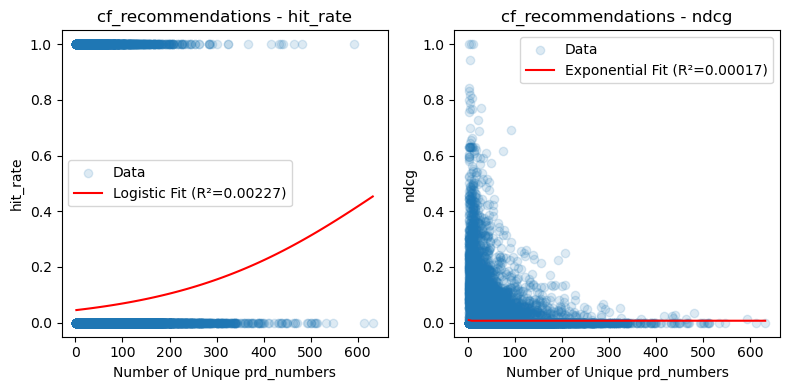

In [69]:
# defining the exponential function
def exponential_func(x, a, b, c):
    return a * np.exp(-b * x) + c

def inverse_func(x, a, b, c):
    return a / (x + b) + c

def log_func(x, a, b, c):
    return a * np.log(x + b) + c

# removing outliers
merged_df_filtered = merged_df[merged_df["prd_number"] < 1500]

# initializing subplots
n_recommenders = len(RECOMMENDERS)
n_metrics = len(EVALUATION_METRICS)
fig, axes = plt.subplots(n_recommenders, n_metrics, figsize=(4 * n_metrics, 4 * n_recommenders))

for r_idx, recommender in enumerate(RECOMMENDERS):
    # plotting each metric against the number of unique prd_numbers
    for m_idx, metric in enumerate(EVALUATION_METRICS):
        ax = axes[r_idx, m_idx] if n_recommenders > 1 else axes[m_idx]
        x = merged_df_filtered["prd_number"].values
        y = merged_df_filtered[metric].values
        ax.scatter(x, y, alpha=0.15, label="Data")
        
        # fitting based on the metric type
        if metric == "hit_rate":
            # logistic regression fit
            x_reshaped = x.reshape(-1, 1)
            logistic_model = LogisticRegression()
            logistic_model.fit(x_reshaped, y)
            x_vals = np.linspace(x_reshaped.min(), x_reshaped.max(), 100).reshape(-1, 1)
            y_vals = logistic_model.predict_proba(x_vals)[:, 1]

            # compute R²
            y_pred = logistic_model.predict_proba(x_reshaped)[:, 1]
            r2 = compute_r2(y, y_pred)

            # plot logistic fit
            ax.plot(x_vals, y_vals, color="red", label=f"Logistic Fit (R²={r2:.5f})")
        
        elif metric == "ndcg":
            # exponential fit
            try:
                popt, _ = curve_fit(exponential_func, x, y)
                x_vals = np.linspace(x.min(), x.max(), 100)
                y_vals = exponential_func(x_vals, *popt)

                # compute R²
                y_pred = exponential_func(x, *popt)
                r2 = compute_r2(y, y_pred)
                
                # plot exponential fit
                ax.plot(x_vals, y_vals, color="red", label=f"Exponential Fit (R²={r2:.5f})")

            except RuntimeError:
                print(f"Exponential fit failed for {recommender} - {metric}")

        # setting titles and labels
        ax.set_title(f"{recommender} - {metric}")
        ax.set_xlabel("Number of Unique prd_numbers")
        ax.set_ylabel(metric)
        ax.legend()

plt.tight_layout()
plt.show()

Normalizing the number of unique prd_numbers:

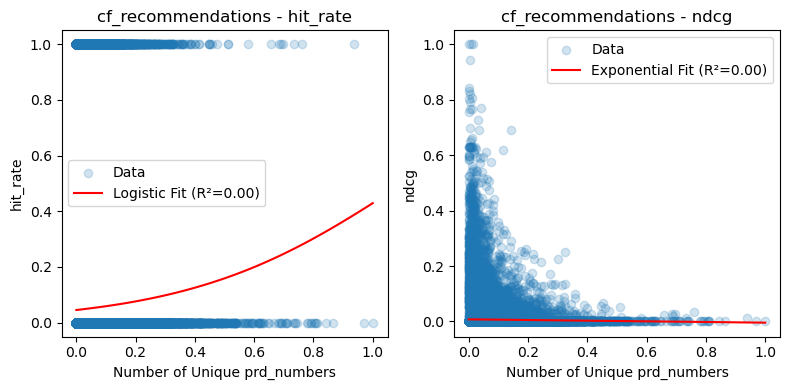

In [67]:
# defining the exponential function
def exponential_func(x, a, b, c):
    return a * np.exp(-b * x) + c

# removing outliers
merged_df_filtered = merged_df[merged_df["prd_number"] < 1500]

# initializing subplots
n_recommenders = len(RECOMMENDERS)
n_metrics = len(EVALUATION_METRICS)
fig, axes = plt.subplots(n_recommenders, n_metrics, figsize=(4 * n_metrics, 4 * n_recommenders))

for r_idx, recommender in enumerate(RECOMMENDERS):
    # plotting each metric against the number of unique prd_numbers
    for m_idx, metric in enumerate(EVALUATION_METRICS):
        ax = axes[r_idx, m_idx] if n_recommenders > 1 else axes[m_idx]
        X = merged_df_filtered["prd_number"]
        x_norm = (X - X.min()) / (X.max() - X.min())
        ax.scatter(x_norm, merged_df_filtered[metric], alpha=0.2, label="Data")
        
        if metric == "hit_rate":
            # logistic regression fit
            X = merged_df_filtered["prd_number"].values.reshape(-1, 1)
            x_norm = (X - X.min()) / (X.max() - X.min())  
            y = merged_df_filtered[metric].values
            logistic_model = LogisticRegression()
            logistic_model.fit(x_norm, y)
            x_vals = np.linspace(x_norm.min(), x_norm.max(), 100).reshape(-1, 1)
            y_vals = logistic_model.predict_proba(x_vals)[:, 1]
            
            # compute R²
            y_pred = logistic_model.predict_proba(x_norm)[:, 1]
            r2 = compute_r2(y, y_pred)
            
            # plot logistic fit
            ax.plot(x_vals, y_vals, color="red", label=f"Logistic Fit (R²={r2:.2f})")
        
        elif metric == "ndcg":
            # exponential fit
            x_data = merged_df_filtered["prd_number"].values
            x_norm = (x_data - x_data.min()) / (x_data.max() - x_data.min())  
            y_data = merged_df_filtered[metric].values
            
            try:
                popt, _ = curve_fit(exponential_func, x_norm, y_data)
                x_vals = np.linspace(x_norm.min(), x_norm.max(), 100)
                y_vals = exponential_func(x_vals, *popt)
                
                # compute R²
                y_pred = exponential_func(x_norm, *popt)
                r2 = compute_r2(y_data, y_pred)
                
                # plot exponential fit
                ax.plot(x_vals, y_vals, color="red", label=f"Exponential Fit (R²={r2:.2f})")
            except RuntimeError:
                print(f"Exponential fit failed for {recommender} - {metric}")
        
        # setting titles and labels
        ax.set_title(f"{recommender} - {metric}")
        ax.set_xlabel("Number of Unique prd_numbers")
        ax.set_ylabel(metric)
        ax.legend()

plt.tight_layout()
plt.show()

### Group Fairness of Genres
Measuring if the distribution of genres is the same in the training data and among the recommendations. 

In [6]:
# loading training data
train_df = pd.read_parquet("../" + TRAIN_DATA_PATH)

# loading episode metadata
meta_df = pd.read_parquet("../" + METADATA_PATH)

# loading recommendations
with open("../" + RECOMMENDATIONS_PATH, "r") as file:
    data = json.load(file)

Distribution of genres in training data:

In [ ]:
# joining on metadata
train_w_meta_df = train_df.merge(meta_df.reset_index(), on="prd_number", how="left")

# measuring the distribution
train_genre_distr = train_w_meta_df["genre"].value_counts(normalize=True)

# formatting distribution as dataframe
train_genre_df = pd.DataFrame(train_genre_distr)
train_genre_df["recommender"] = "train"

# saving as csv
train_genre_df.to_csv("../results/genre_distributions.csv")

Distribution of genres in recommendations:

In [ ]:
# loading recommendations
with open("../" + RECOMMENDATIONS_PATH, "r") as file:
    rec_data = json.load(file)

# iterating over each recommender
for recommender in RECOMMENDERS:
    # obtaining all recommendations 
    recommendations = rec_data[recommender]
    all_recommendations = [episode for rec_list in recommendations.values() for episode in rec_list]

    # initializing dataframe
    int_rec_df = {"prd_number": all_recommendations}
    recommendations_df = pd.DataFrame(int_rec_df)
    
    # left joining metadata
    recommendations_w_meta_df = recommendations_df.merge(meta_df.reset_index(), on="prd_number", how="left")

    # computing genre distribution
    rec_genre_distr = recommendations_w_meta_df["genre"].value_counts(normalize=True)
    
    # adding 0% for missing genres
    all_genres = set(train_genre_df.index)
    rec_genres = set(rec_genre_distr.index)
    missing_genres = all_genres.difference(rec_genres)
    for genre in missing_genres:
        rec_genre_distr.loc[genre] = 0

    # formatting distribution as dataframe
    rec_genre_df = pd.DataFrame(rec_genre_distr)
    rec_genre_df["recommender"] = recommender

    # appending the genre distribution of the recommender to a csv file
    rec_genre_df.to_csv("../results/genre_distributions.csv", mode='a', header=False, index=True)

Measuring the difference between the distributions and if the distributions are significantly different from each other.  

This is done by computing the KL divergence and performing a permutation test of significance.

In [23]:
# genre distribution from training data as target distribution
p = train_genre_distr.to_dict()

# loading genre distributions data
genre_dist_df = pd.read_csv("../results/genre_distributions.csv")

# comparing the genre distributions from the recommendations for each recommender
for recommender in RECOMMENDERS:
    
    # retrieving candidate distribution from genre_dist_df
    rec_genre_dist_df = genre_dist_df[genre_dist_df["recommender"] == recommender]
    rec_genre_dist_df.drop(columns="recommender", inplace=True)
    q = rec_genre_dist_df.set_index("genre")["proportion"].to_dict()
    
    # computing KL divergence and the corresponding p-value
    observed_kl, p_value = utils.permutation_test(p, q)
    print(f"KL divergence for {recommender}: {observed_kl:.3f}")
    print(f"With p-value: {p_value:.3f}")

C:\Users\sewr\AppData\Local\Temp\ipykernel_24928\570379205.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  rec_genre_dist_df.drop(columns="recommender", inplace=True)


KL divergence for cf_recommendations: 3.244
With p-value: 0.000
